In [3]:
%env CUDA_VISIBLE_DEVICES=4

env: CUDA_VISIBLE_DEVICES=4


In [4]:
import sys, os
from pathlib import Path

# 프로젝트 루트 등록
sys.path += [
    "/home/lcw/openvla-oft",
    "/home/lcw/openvla-oft/vla-scripts",
]

import tensorflow_datasets as tfds
from transformers import AutoProcessor

from finetune import (
    FinetuneConfig,
    RLDSBatchTransform_epi,
    PaddedCollatorForActionPrediction,
    ActionTokenizer,
    PurePromptBuilder,
    EpisodicRLDSDataset,   # ← PyTorch Dataset (RLDS 래핑)
)


In [5]:
cfg = FinetuneConfig(
    vla_path="openvla/openvla-7b",
    data_root_dir=Path("/home/lcw/openvla-oft/datasets/modified_libero_rlds"),
    dataset_name="libero_10_no_noops",
    num_images_in_input=2,
    use_proprio=True,
    image_aug=False,
)


In [6]:
# dataset_info.json이 있는 디렉터리까지 지정
version_dir = cfg.data_root_dir / cfg.dataset_name / "1.0.0"
builder = tfds.builder_from_directory(version_dir)
builder.download_and_prepare()


In [7]:
processor = AutoProcessor.from_pretrained(cfg.vla_path, trust_remote_code=True)
action_tok = ActionTokenizer(processor.tokenizer)

batch_transform = RLDSBatchTransform_epi(
    action_tokenizer = action_tok,
    base_tokenizer   = processor.tokenizer,
    image_transform  = processor.image_processor.apply_transform,
    prompt_builder_fn= PurePromptBuilder,
    use_wrist_image  = cfg.num_images_in_input > 1,
    use_proprio      = cfg.use_proprio,
)

resize_hw = tuple(processor.image_processor.input_sizes[0][1:])  # (H, W)


In [8]:
from prismatic.vla.datasets.datasets import EpisodicDataset

train_dataset = EpisodicDataset(
    data_root_dir       = cfg.data_root_dir,         # "datasets/modified_libero_rlds"
    data_mix            = cfg.dataset_name,          # "libero_10_no_noops"
    batch_transform     = batch_transform,
    resize_resolution   = tuple(processor.image_processor.input_sizes[0][1:]),
    shuffle_buffer_size = cfg.shuffle_buffer_size,   # 예: 0
    image_aug           = cfg.image_aug,             # True/False
)

2025-06-24 17:01:48.561603: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


06/24 [17:01:49] INFO     | >> [*] Loading existing dataset statistics from                       ]8;id=269089;file:///home/lcw/openvla-oft/prismatic/vla/datasets/rlds/utils/data_utils.py\data_utils.py]8;;\:]8;id=89138;file:///home/lcw/openvla-oft/prismatic/vla/datasets/rlds/utils/data_utils.py#201\201]8;;\
                          /home/lcw/openvla-oft/datasets/modified_libero_rlds/libero_10_no_noops/                  
                          1.0.0/dataset_statistics_f1f4cb06e922a6979da3f480f311f18217dce47441ef4b                  
                          608b3eaaa06c950589.json.                                                                 

2025-06-24 17:01:49.329433: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


In [9]:
collator = PaddedCollatorForActionPrediction(
    processor.tokenizer.model_max_length,   # max_length
    processor.tokenizer.pad_token_id,       # pad_token_id
    "right"                                 # padding_side
)

In [10]:
from torch.utils.data import DataLoader

loader = DataLoader(
    train_dataset,
    batch_size  = 4,
    shuffle     = False,
    collate_fn  = collator,
    num_workers = 0,
)


In [11]:
batch = next(iter(loader))

In [12]:
for key, val in batch.items():
    if hasattr(val, "shape"):
        print(f"{key:20s} → {tuple(val.shape)}")

pixel_values         → (4, 12, 224, 224)
proprio              → (4, 8)
input_ids            → (4, 93)
attention_mask       → (4, 93)
labels               → (4, 93)
actions              → (4, 8, 7)


06/24 [17:02:53] INFO     | >> Failed to extract font properties from                          ]8;id=763100;file:///home/lcw/miniconda3/envs/openvla-oft/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=180790;file:///home/lcw/miniconda3/envs/openvla-oft/lib/python3.10/site-packages/matplotlib/font_manager.py#1107\1107]8;;\
                          /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: Can not load face                     
                          (unknown file format; error code 0x2)                                                    

                 INFO     | >> generated new fontManager                                       ]8;id=275386;file:///home/lcw/miniconda3/envs/openvla-oft/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=444878;file:///home/lcw/miniconda3/envs/openvla-oft/lib/python3.10/site-packages/matplotlib/font_manager.py#1639\1639]8;;\

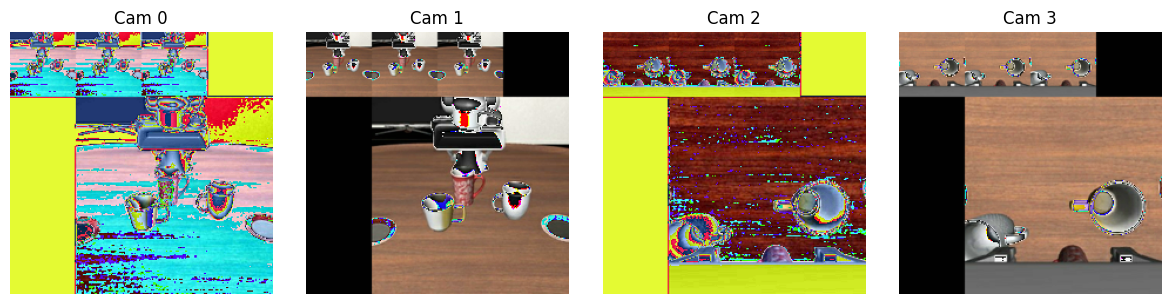

In [13]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

imgs = batch["pixel_values"][3]
imgs = imgs.reshape(-1, 3, 224, 224)


fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, img_t in enumerate(imgs):
    img_pil = TF.to_pil_image(img_t)
    axs[i].imshow(img_pil)
    axs[i].set_title(f"Cam {i}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()


📊 Norms: [11.934259414672852, 10.93161678314209, 11.268964767456055, 10.829066276550293]
✅ Keep mask: [True, True, True, True]


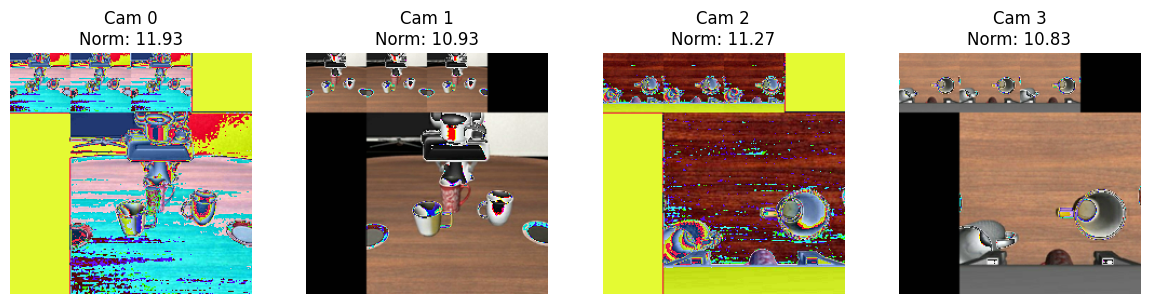

In [14]:
from transformers import CLIPProcessor, CLIPModel
import torchvision.transforms.functional as TF
import torch
import matplotlib.pyplot as plt

# 1. 이미지 추출 (4개 카메라 뷰)
imgs = batch["pixel_values"][3]          # (12, 224, 224)
imgs = imgs.reshape(-1, 3, 224, 224)     # (4, 3, 224, 224)

# 2. CLIP 준비
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").eval().cuda()
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 3. PIL 변환 + CLIP 입력 변환
imgs_pil = [TF.to_pil_image(img) for img in imgs]
clip_inputs = clip_processor(images=imgs_pil, return_tensors="pt").to("cuda")

# 4. CLIP embedding 추출 + norm 계산
with torch.no_grad():
    clip_embeds = clip_model.get_image_features(**clip_inputs)  # (4, 512)

norms = torch.norm(clip_embeds, dim=-1)  # (4,)
print("📊 Norms:", norms.tolist())

# 5. Norm threshold로 마스킹
threshold = 5.0
mask = norms > threshold  # BoolTensor of shape (4,)
print("✅ Keep mask:", mask.tolist())

# 6. 마스킹 후 유효 이미지만 추출
valid_imgs = [img for img, keep in zip(imgs_pil, mask) if keep]

# 7. 시각화
fig, axs = plt.subplots(1, len(imgs_pil), figsize=(12, 3))
for i, (img_pil, norm_val) in enumerate(zip(imgs_pil, norms)):
    axs[i].imshow(img_pil)
    axs[i].set_title(f"Cam {i}\nNorm: {norm_val:.2f}")
    if not mask[i]:
        axs[i].spines['bottom'].set_color('red')  # 제거된 뷰 강조
        axs[i].spines['bottom'].set_linewidth(3)
    axs[i].axis("off")
plt.tight_layout()
plt.show()

# 8. memory grid 만들 때 valid_imgs만 사용
# memory_img, memory_mask = generator.make_memory_grid(valid_imgs)
